<a href="https://colab.research.google.com/github/dannyxplicit/ML_-Cough-Diagnosis/blob/main/Copy_of_softwareTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libs
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = os.path.abspath('/content/drive/MyDrive/AI/jm1.csv')


In [4]:
df = pd.read_csv(data_dir)

In [5]:
print(df.head())  # View first few rows
print(df.info())  # Check data types and missing values

     loc  v(g)  ev(g)  iv(g)      n        v     l      d       i         e  \
0    1.1   1.4    1.4    1.4    1.3     1.30  1.30   1.30    1.30      1.30   
1    1.0   1.0    1.0    1.0    1.0     1.00  1.00   1.00    1.00      1.00   
2   72.0   7.0    1.0    6.0  198.0  1134.13  0.05  20.31   55.85  23029.10   
3  190.0   3.0    1.0    3.0  600.0  4348.76  0.06  17.06  254.87  74202.67   
4   37.0   4.0    1.0    4.0  126.0   599.12  0.06  17.19   34.86  10297.30   

   ...  lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
0  ...       2          2        2                  2      1.2        1.2   
1  ...       1          1        1                  1        1          1   
2  ...      51         10        8                  1       17         36   
3  ...     129         29       28                  2       17        135   
4  ...      28          1        6                  0       11         16   

  total_Op total_Opnd branchCount defects  
0      1.2        

defects
False    0.806523
True     0.193477
Name: proportion, dtype: float64


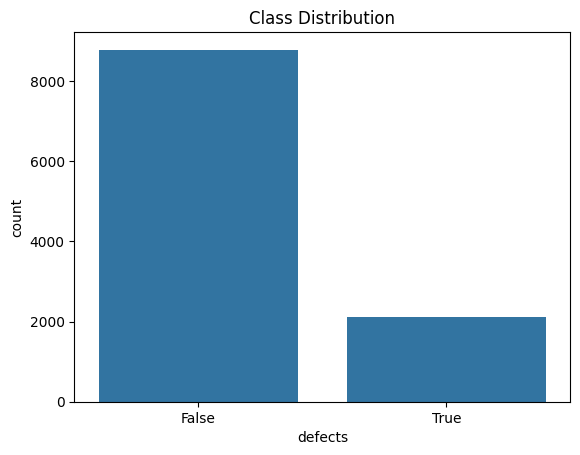

In [6]:
print(df['defects'].value_counts(normalize=True))  # Percentage of true/false
sns.countplot(x='defects', data=df)
plt.title('Class Distribution')
plt.show()

In [7]:
#summarize features
print(df.describe())  # Stats for numeric features

                loc          v(g)         ev(g)         iv(g)             n  \
count  10885.000000  10885.000000  10885.000000  10885.000000  10885.000000   
mean      42.016178      6.348590      3.401047      4.001599    114.389738   
std       76.593332     13.019695      6.771869      9.116889    249.502091   
min        1.000000      1.000000      1.000000      1.000000      0.000000   
25%       11.000000      2.000000      1.000000      1.000000     14.000000   
50%       23.000000      3.000000      1.000000      2.000000     49.000000   
75%       46.000000      7.000000      3.000000      4.000000    119.000000   
max     3442.000000    470.000000    165.000000    402.000000   8441.000000   

                  v             l             d             i             e  \
count  10885.000000  10885.000000  10885.000000  10885.000000  1.088500e+04   
mean     673.758017      0.135335     14.177237     29.439544  3.683637e+04   
std     1938.856196      0.160538     18.709900    

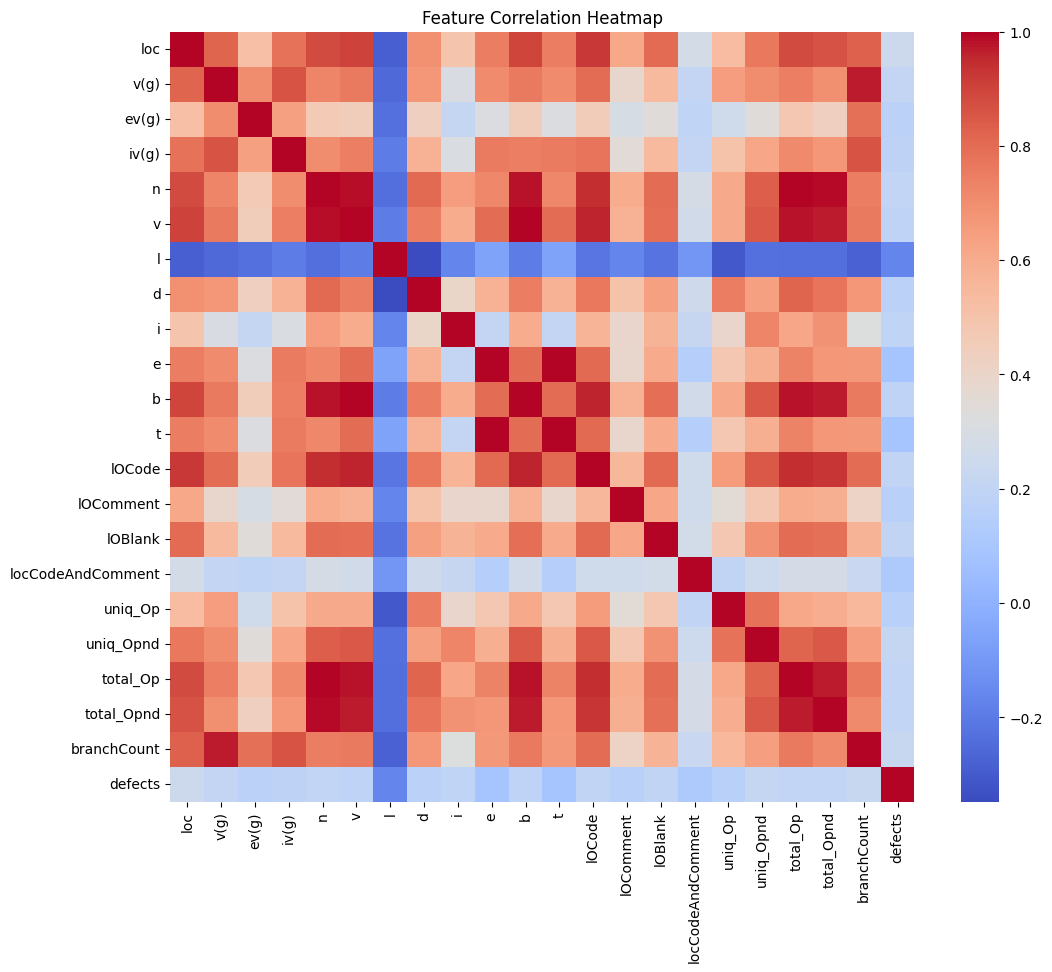

In [8]:
# Visualize correlations

# Identify columns that are of object type but should be numeric
object_cols = df.select_dtypes(include='object').columns

# Replace '?' with NaN and convert to numeric for these columns
for col in object_cols:
    df[col] = df[col].replace('?', np.nan)
    df[col] = pd.to_numeric(df[col])

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

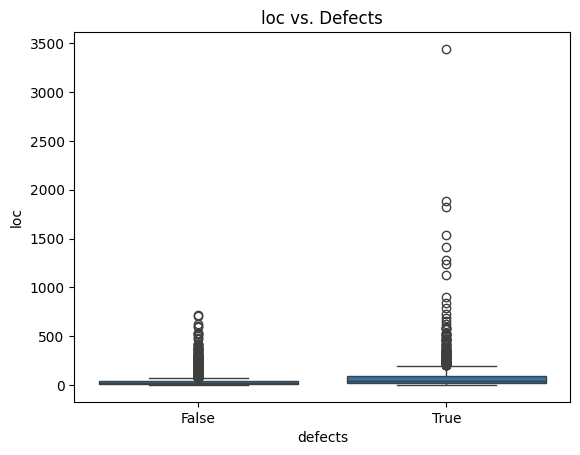

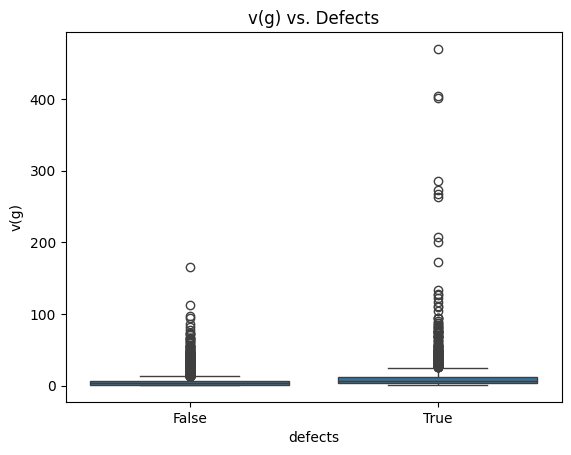

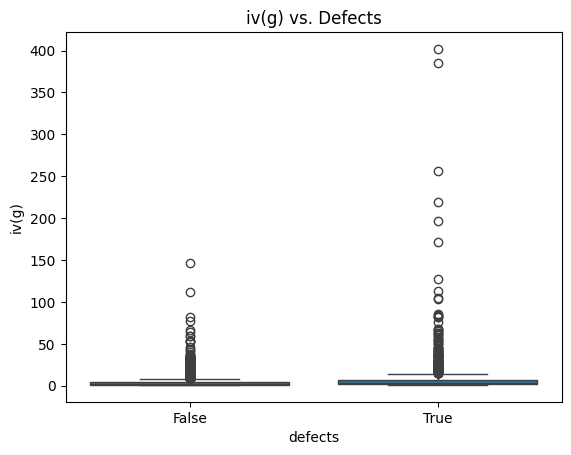

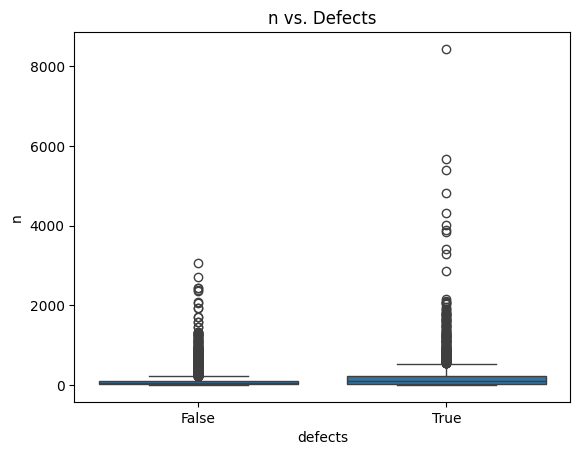

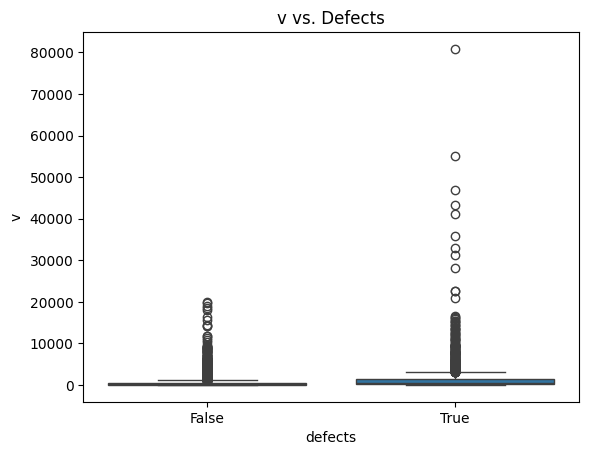

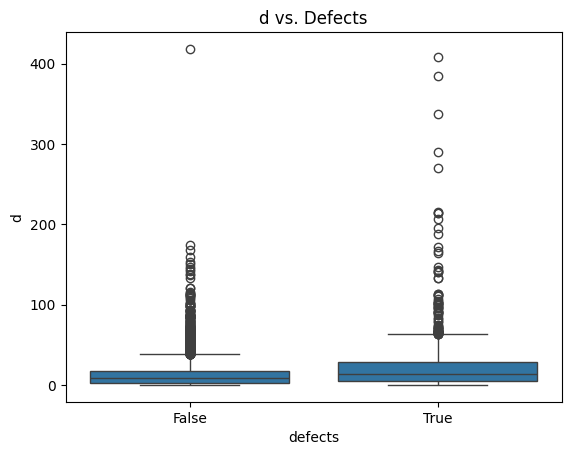

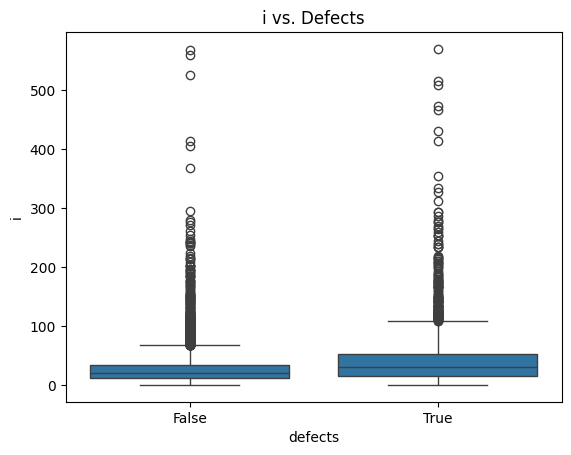

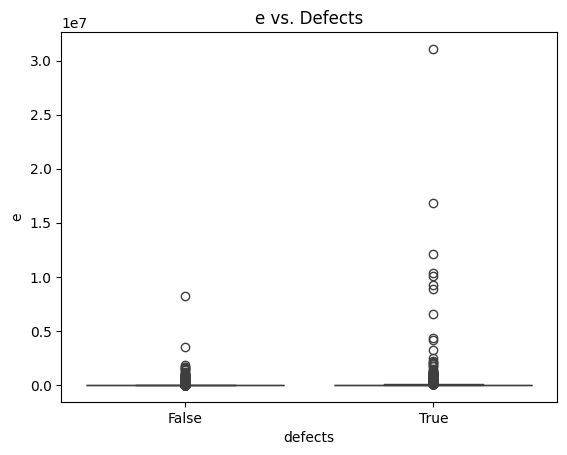

In [9]:
#Boxplots for key features vs. target
key_features = ['loc', 'v(g)', 'iv(g)', 'n', 'v', 'd', 'i', 'e']
for feature in key_features:
    sns.boxplot(x='defects', y=feature, data=df)
    plt.title(f'{feature} vs. Defects')
    plt.show()

In [10]:
#Step 3: Data Preprocessing Map target to numeric (0 = false/non-defective, 1 = true/defective)
df['defects'] = df['defects'].map({False: 0, True: 1})  # Or {'false': 0, 'true': 1} if strings

In [11]:
#Split features and target:Python
X = df.drop('defects', axis=1)
y = df['defects']

In [12]:
#Train-test split (stratified to preserve imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [13]:
#Scale features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
#Handle imbalance with SMOTE (oversample minority class)
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Impute missing values in the scaled data before SMOTE
imputer = SimpleImputer(strategy='median') # Using median to be robust to outliers
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
X_test_scaled_imputed = imputer.transform(X_test_scaled) # Apply the same imputer to test set

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled_imputed, y_train)
print(pd.Series(y_train_res).value_counts())  # Check balanced

defects
0    7023
1    7023
Name: count, dtype: int64


Step 10: Model Training and Evaluation
Train multiple models to compare. Focus on metrics: Precision, Recall, F1 (emphasize recall for defects), AUC-ROC.

In [15]:
#logisitic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_res, y_train_res)
preds_lr = lr.predict(X_test_scaled_imputed)
print("Logistic Regression:")
print(classification_report(y_test, preds_lr))
print("AUC-ROC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled_imputed)[:, 1]))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1756
           1       0.33      0.59      0.42       421

    accuracy                           0.69      2177
   macro avg       0.61      0.65      0.61      2177
weighted avg       0.77      0.69      0.72      2177

AUC-ROC: 0.6974573772177103


In [16]:
#Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
preds_rf = rf.predict(X_test_scaled)
print("Random Forest:")
print(classification_report(y_test, preds_rf))
print("AUC-ROC:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))

Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1756
           1       0.44      0.38      0.41       421

    accuracy                           0.79      2177
   macro avg       0.65      0.63      0.64      2177
weighted avg       0.78      0.79      0.78      2177

AUC-ROC: 0.7358395240749057


In [17]:
#XGBoost (Advanced)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)
preds_xgb = xgb.predict(X_test_scaled)
print("XGBoost:")
print(classification_report(y_test, preds_xgb))
print("AUC-ROC:", roc_auc_score(y_test, xgb.predict_proba(X_test_scaled)[:, 1]))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:08:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1756
           1       0.47      0.35      0.40       421

    accuracy                           0.80      2177
   macro avg       0.66      0.63      0.64      2177
weighted avg       0.78      0.80      0.79      2177

AUC-ROC: 0.7211190407912607


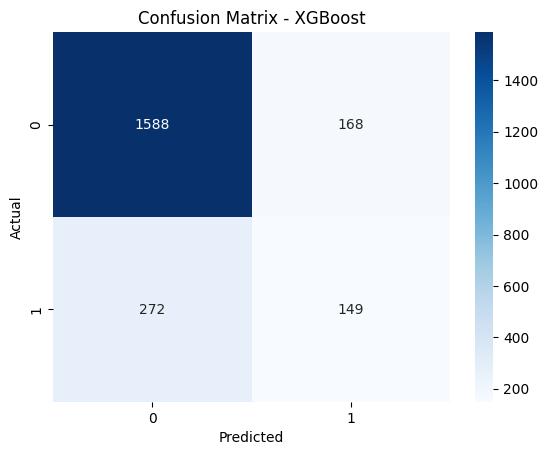

In [18]:
#Confusion Matrix for Best Model (e.g., XGBoost
cm = confusion_matrix(y_test, preds_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

Step 5: Feature Importance Analysis
For Random Forest or XGBoost:

        Feature  Importance
0           loc    0.132042
3         iv(g)    0.095927
14      lOBlank    0.085821
1          v(g)    0.065992
20  branchCount    0.061348
12       lOCode    0.047605
17    uniq_Opnd    0.041577
16      uniq_Op    0.041075
8             i    0.038000
18     total_Op    0.037213


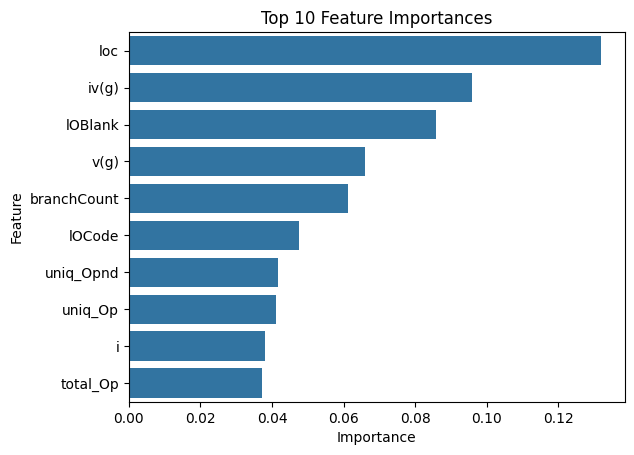

In [19]:
# For Random Forest
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance.head(10))

# Plot
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.show()